In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import modules as mod
import networkx as nx
import scipy.optimize
from scipy.optimize import curve_fit


In [21]:
# Number of market participants 
N = 1600 

# Number of fundamentalists and chartists
N_FUND = 800
N_CHART = 800

# Initial price of the asset traded
P_0 = 100

# Global fundamental price 
P_F = 120

# Variation around the global fundamental price 
THETA = 30

# Maximum extension for chartists' timesteps window 
T_MAX = 15

# Sensitivity of forecasts for fundamentalists
PHI = 2.0

# Sensitivity of forecasts for chartists 
KAPPA = 2.0

# level of information dissipation among the agents
ALPHA = 0.95

# Weight of the market imbalance
DELTA = 0.05

# Intervals of variation for the stochastic noise term 
SIGMA = 30

# Sensitivity threshold for choosing the status
TAO = 20

# Asset quantity for each trader
Q = 50

# Initializing traders' wealth (W), money (M), and asset quantity(Q)
M = 35000  
Q = 50 
W = [M + Q * P_0 for _ in range(N)] 

# Information Threshold
Ith = 1

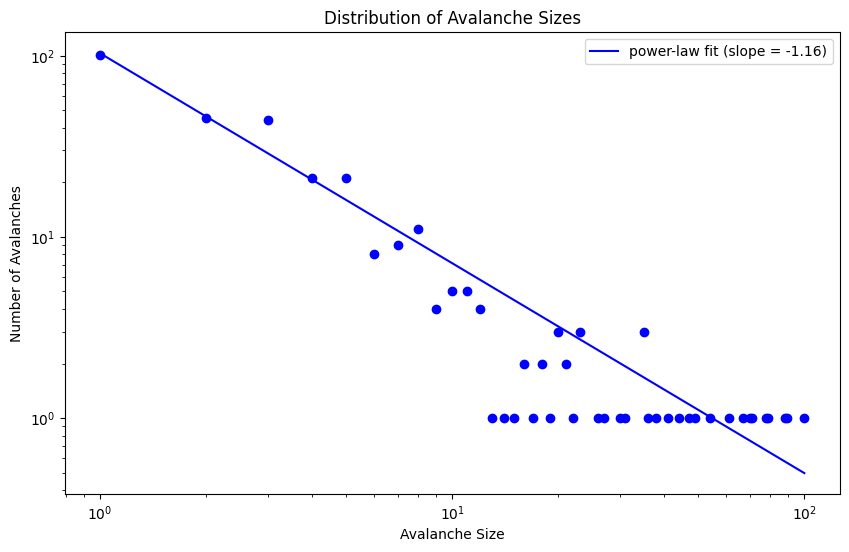

In [24]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.4)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100

def propagate_info(agent_index, agents, network, ALPHA, Ith, info_counts):
    agent = agents[agent_index]
    neighbors = list(network.neighbors(agent_index))
    if agent['info'] >= Ith:
        N_nn = len(neighbors)
        info_counts[-1] += 1
        store_info = agent['info']
        agent['info'] = 0
        for neighbor in neighbors:
            agents[neighbor]['info'] += (ALPHA / N_nn) * store_info
            agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)
            if agents[neighbor]['info'] >= Ith:
                agents[neighbor]['decision'] = agent['decision']
                propagate_info(neighbor, agents, network, ALPHA, Ith, info_counts)  # Recursive call

                
# Simulate market dynamics
for t in range(1, 10000):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_count = 0  # Counter for agents with info > 1
    info_counts.append(info_count)
    copy_agents = agents # for the step [0, (I_th - I_max(t))]
    for i, agent in enumerate(agents):
        # Increase information assets
#         print("Ith - I_max:", Ith - max(agents['info']))
        agent['info'] += np.random.uniform(0, (Ith - max(copy_agents['info'])))
        # Update expected price and actual price for each agent at each time step
        agent['expected_price'] = np.random.uniform(low=50, high=150)
            

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
            
    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        propagate_info(i, agents, network, ALPHA, Ith, info_counts)
    
    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])

# Filter out the time steps where no avalanche occurred
avalanche_sizes = np.array(info_counts)
avalanche_sizes = avalanche_sizes[avalanche_sizes > 0]

# Calculate the unique avalanche sizes and their counts
avalanche_sizes, counts = np.unique(avalanche_sizes, return_counts=True)

# Define the power-law function for fitting
def power_law(x, a, b):
    return a * np.power(x, b)

# Fit the power-law curve to the data
params, _ = curve_fit(power_law, avalanche_sizes, counts)

# Unpack fitting parameters for plotting
a, b = params

# Create a log-log plot of the avalanche sizes and their counts
plt.figure(figsize=(10, 6))
plt.scatter(avalanche_sizes, counts, color='blue')  # Scatter plot of the raw data

# Generate points for the fitted line
fitted_line = power_law(avalanche_sizes, a, b)

# Plot the fitted line
plt.plot(avalanche_sizes, fitted_line, label=f'power-law fit (slope = {b:.2f})', color='blue')

# Set the plot to log-log scale
plt.xscale('log')
plt.yscale('log')

# Label the axes and add a title
plt.xlabel('Avalanche Size')
plt.ylabel('Number of Avalanches')
plt.title('Distribution of Avalanche Sizes')

# Add a legend
plt.legend()

# Show the plot
plt.show()

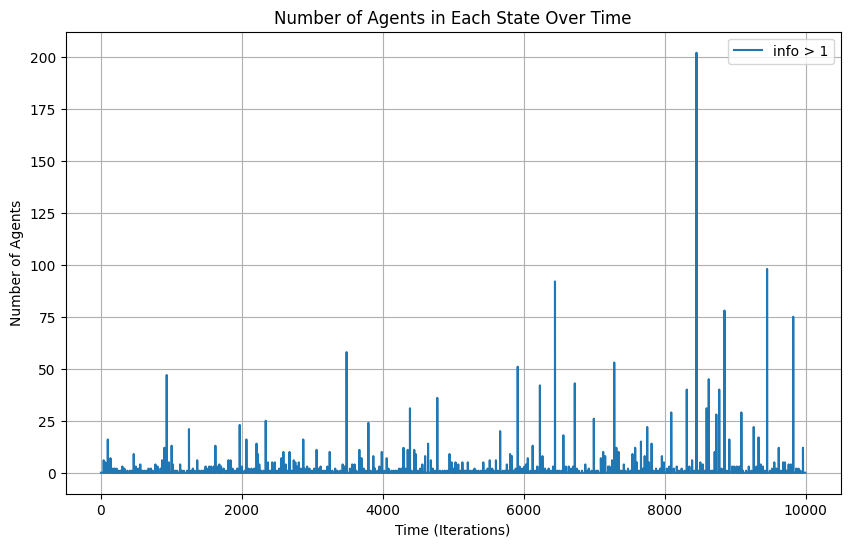

In [26]:
# Create network
network = nx.watts_strogatz_graph(N, 4, 0.4)

# Initialize agent attributes
agents = np.zeros(N, dtype=[('type', 'U10'), ('wealth', 'f8'), ('money', 'f8'), ('quantity', 'f8'), ('expected_price', 'f8'), ('decision', 'U10'), ('info', 'f8')])
for i in range(N):
    agents[i] = (np.random.choice(['fund', 'chart']), W[i], M, Q, np.random.uniform(low=50, high=150), np.random.choice(['buy', 'sell', 'hold']), np.random.uniform(0, Ith))

# Initialize a dictionary to store the number of agents in each state before the simulation starts
state_counts = {'buy': [], 'sell': [], 'hold': []}
info_counts = []  # List to store the count of agents with info > 1 at each time step

actual_price = 100

def propagate_info(agent_index, agents, network, ALPHA, Ith, info_counts):
    agent = agents[agent_index]
    neighbors = list(network.neighbors(agent_index))
    if agent['info'] >= Ith:
        N_nn = len(neighbors)
        info_counts[-1] += 1
        store_info = agent['info']
        agent['info'] = 0
        for neighbor in neighbors:
            agents[neighbor]['info'] += (ALPHA / N_nn) * store_info
            agents[neighbor]['info'] = min(agents[neighbor]['info'], np.finfo(float).max)
            if agents[neighbor]['info'] >= Ith:
                agents[neighbor]['decision'] = agent['decision']
                propagate_info(neighbor, agents, network, ALPHA, Ith, info_counts)  # Recursive call

                
# Simulate market dynamics
for t in range(1, 10000):  # Assume 100 time steps for the simulation
    # Update agent states and trading decisions
    info_count = 0  # Counter for agents with info > 1
    info_counts.append(info_count)
    copy_agents = agents # for the step [0, (I_th - I_max(t))]
    for i, agent in enumerate(agents):
        # Increase information assets
#         print("Ith - I_max:", Ith - max(agents['info']))
        agent['info'] += np.random.uniform(0, (Ith - max(copy_agents['info'])))
        # Update expected price and actual price for each agent at each time step
        agent['expected_price'] = np.random.uniform(low=50, high=150)
            

    for i, agent in enumerate(agents):  
        if agent['type'] == 'fund':
            # Fundamentalist agents buy if price is lower than fundamental price, sell if higher
            price_difference = agent['expected_price'] - actual_price
            if abs(price_difference) < TAO:
                # If the expected price is within the threshold TAO, hold
                agent['decision'] = 'hold'
            elif price_difference > TAO and agent['money'] > 0:
                # If the expected price is sufficiently greater than the actual price and the agent has money, buy
                agent['decision'] = 'buy'
            elif price_difference < -TAO and agent['quantity'] > 0:
                # If the expected price is sufficiently lower than the actual price and the agent has the asset, sell
                agent['decision'] = 'sell'
            
    # Information dissemination and agent interaction
    for i, agent in enumerate(agents):
        propagate_info(i, agents, network, ALPHA, Ith, info_counts)
    
    # Update state counts
    current_state_counts = {'buy': 0, 'sell': 0, 'hold': 0}
    for agent in agents:
        current_state_counts[agent['decision']] += 1
    for state in state_counts:
        state_counts[state].append(current_state_counts[state])
        
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
# for state, counts in state_counts.items():
#     plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(info_counts)), info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.show()


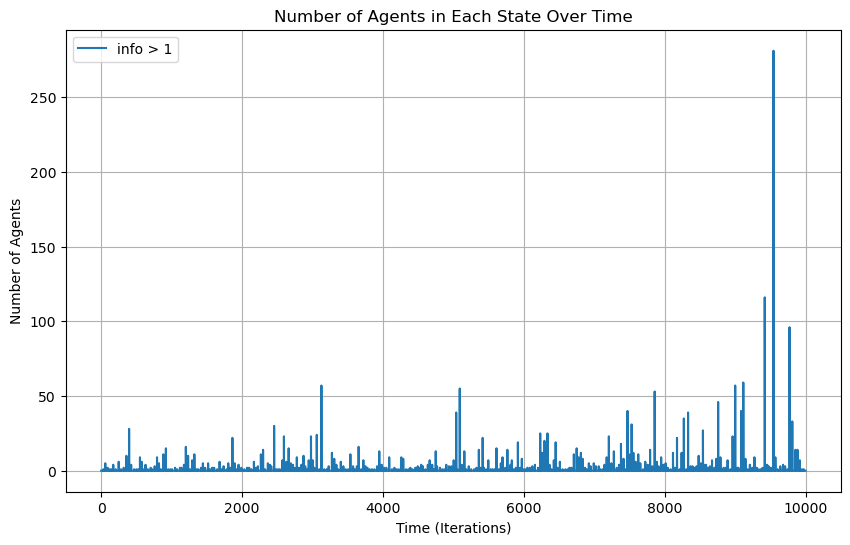

In [88]:
# After the simulation ends, create a chart to show the number of agents in each state over time
plt.figure(figsize=(10, 6))
# for state, counts in state_counts.items():
#     plt.plot(range(len(counts)), counts, label=state)
plt.plot(range(len(info_counts)), info_counts, label='info > 1')  # Plot the count of agents with info > 1
plt.xlabel('Time (Iterations)')
plt.ylabel('Number of Agents')
plt.title('Number of Agents in Each State Over Time')
plt.legend()
plt.grid(True)
plt.savefig("soc_network.png")
plt.show()